# Introduction

This experiment is to test the spherical warping algorithm. 

We have tested cylindrical warping algorithm. It uses only the focal length and all transformation is symmetrical and it's useful for only the middle row. For other rows, I mean non-equatorical rows, it would be supposed images should be transformed asymmetrically. We have thought once that it could be done by combining two warp transforms: cylindrical warping and perspective warping. It should be tested too.

When we consider arbitrary row images, we should determin its warping algorithm. Many spherical algorithms including opencv library needs two matrices for spherical warping - K(intrinsic matrix) and R(rotation matrix).

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import json    
from tqdm import tqdm_notebook

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mptrans

from scipy import ndimage

import cv2 as cv
import imutils

import gc

In [222]:
from libpano import MetaData
from libpano import utils
from libpano import ImageCropper

### Load and parse meta data

In [4]:
ID = 'recent-04'
IMAGE_FOLDER = '../images/' + ID + '/'
JSON_FN = IMAGE_FOLDER + ID + '.json'

In [5]:
meta_data = MetaData.MetaData(IMAGE_FOLDER)
metrics = meta_data.metrics
meta = meta_data.grid_data

In [6]:
print(metrics)

Camera Metrics:
	Focal Length: 4.4589 mm
	Focal Length: 1588.26 px
	Sensor Size: 4.2447996 x 5.6447997 mm
	Pixels per mm: 356.20 x 357.14 px/mm
Panorama Metrics:
	Frame Size: 1512px x 2016px
	Frame Count: 15 x 5
	Interval Angle: 24.0︒ x 36.0︒
	AoV: 50.9081︒ x 64.6661︒
	PPR: 1701.7168px x 1786.2268px
	Panorama Size: 10692.2019px x 5611.5971px



## OpenCV SphericalWarper

OpenCV SphericalWarper needs two matrices K and R. Here, I try to compose those matrices manually and send them to the OpenCV warper class.

In [9]:
meta[meta.yaw == meta.yaw.min()]

row  col             uri     pitch      roll        yaw
30    2    0  img-r1-167.jpg  1.618314  0.672979  17.196747

In [22]:
uri = 'img-r1-167.jpg'

The image `img-r1-167.jpg` is the center image of the entire panorama and let's test it first.

### K
I guess K is consisted of focal lengths and center coordinates.

In [12]:
K = np.array([[metrics.focal_length_px, 0, metrics.FW / 2],
            [0, metrics.focal_length_px, metrics.FH / 2],
             [0, 0, 1]], np.float32)
K

array([[1.5882627e+03, 0.0000000e+00, 7.5600000e+02],
       [0.0000000e+00, 1.5882627e+03, 1.0080000e+03],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

### R
This, the most center image has no any rotation in x and y axis, so theta and huai are all zero.

In [14]:
theta = 0
huai = 0

In [18]:
Rx = np.array([[1,               0,                0],
               [0, math.cos(theta), -math.sin(theta)],
               [0, math.sin(theta),  math.cos(theta)]])
Rx

array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [ 0.,  0.,  1.]])

In [19]:
Ry = np.array([[math.cos(huai), 0, math.sin(huai)],
               [0,              1,              0],
               [-math.sin(huai),0, math.cos(huai)]])
Ry

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-0.,  0.,  1.]])

In [27]:
R = Rx * Ry
R = R.astype(np.float32)
R

array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]], dtype=float32)

### Warping

(2016, 1512, 3)


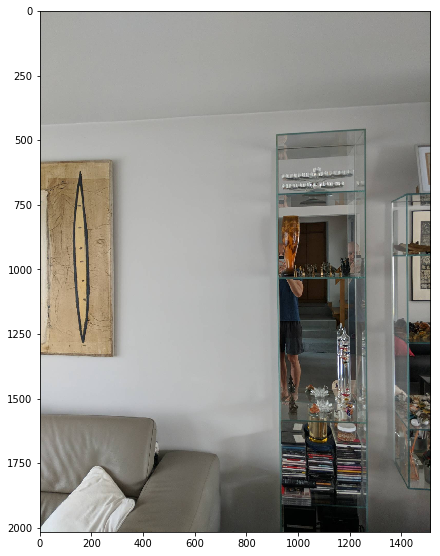

In [55]:
image = cv.imread(IMAGE_FOLDER + uri)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
print(image.shape)

plt.figure(figsize=(7, 10))
plt.imshow(image)
plt.show()

(0, 1)
(2, 1, 3)


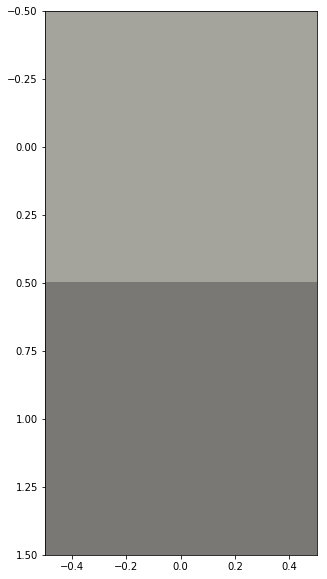

In [51]:
scale = 1.0
warper = cv.PyRotationWarper('spherical', scale)
corner, image_wp = warper.warp(image, K, R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
print(corner)
print(image_wp.shape)

plt.figure(figsize=(7, 10))
plt.imshow(image_wp)
plt.show()

Awful!!! Something wrong. I think the warped image swelled too much. So let's use small scale.

(0, 0)
(1, 1, 3)


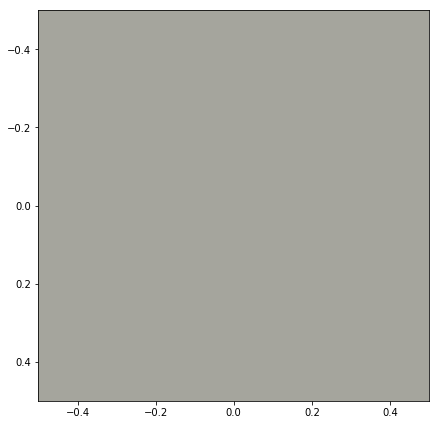

In [52]:
scale = 0.1
warper = cv.PyRotationWarper('spherical', scale)
corner, image_wp = warper.warp(image, K, R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
print(corner)
print(image_wp.shape)

plt.figure(figsize=(7, 10))
plt.imshow(image_wp)
plt.show()

It gets worse. I was wrong, and let's enlarge the scale.

(-4, 10)
(12, 9, 3)


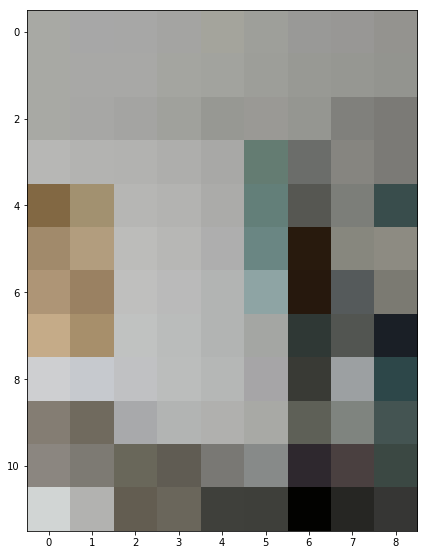

In [56]:
scale = 10
warper = cv.PyRotationWarper('spherical', scale)
corner, image_wp = warper.warp(image, K, R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
print(corner)
print(image_wp.shape)

plt.figure(figsize=(7, 10))
plt.imshow(image_wp)
plt.show()

OK, something happens, bigger one. I guess `scale` is related to the width of `image_wp`.

(-310, 703)
(793, 621, 3)


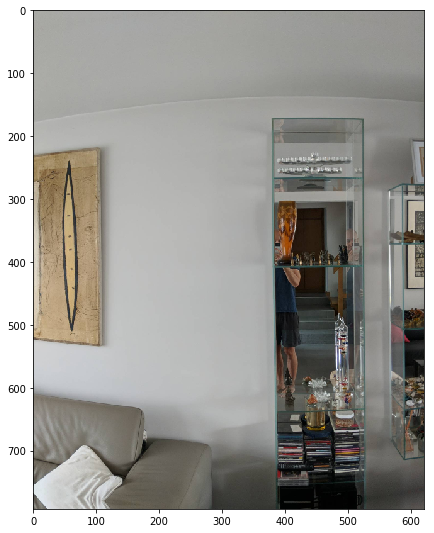

In [54]:
scale = 700
warper = cv.PyRotationWarper('spherical', scale)
corner, image_wp = warper.warp(image, K, R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
print(corner)
print(image_wp.shape)

plt.figure(figsize=(7, 10))
plt.imshow(image_wp)
plt.show()

What about the scale value 1500, the width of original image, and 1701, the radius of the sphere we are making?

(-755, 1709)
(1925, 1510, 3)


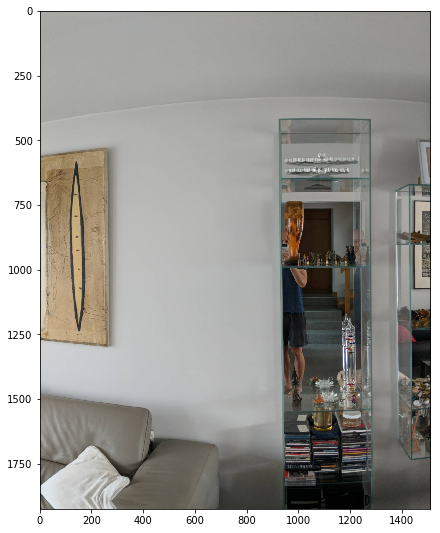

In [151]:
scale = 1701
warper = cv.PyRotationWarper('spherical', scale)
corner, image_wp = warper.warp(image, K, R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
print(corner)
print(image_wp.shape)

plt.figure(figsize=(7, 10))
plt.imshow(image_wp)
plt.show()

## The meaning of `scale`
The scale is likely related to the size of the result image. I calculated the average of the width and height of the result image and the diagonal length of the result image but they are similar to but not the exact scale value - 1500.

What ever it means, it's OK as long as I use the same scale value for every image.

## Focal Length Test
For further experiments, let's make a function.

In [128]:
def my_warp(img, f, cx, cy, theta, huai, draw=True, save=False):
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0,  1]], np.float32)    
    Rx = np.array([[1,               0,                0],
                   [0, math.cos(theta), -math.sin(theta)],
                   [0, math.sin(theta),  math.cos(theta)]])
    Ry = np.array([[math.cos(huai), 0, math.sin(huai)],
                   [0,              1,              0],
                   [-math.sin(huai),0, math.cos(huai)]])    
    R = Rx * Ry
    R = R.astype(np.float32)
    
    scale = 1500
    warper = cv.PyRotationWarper('spherical', scale)
    corner, image_wp = warper.warp(img, K, R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
    
    if draw:
        plt.figure(figsize=(7, 10))
        plt.imshow(image_wp)
        plt.show()

    if save:
        cv.imwrite('temp.jpg', cv.cvtColor(image_wp, cv.COLOR_RGB2BGR))

    return image_wp

### small focal length

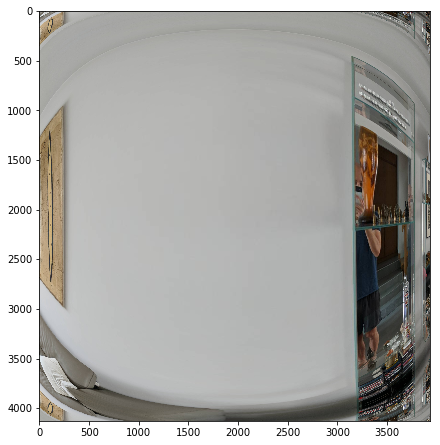

In [129]:
warped = my_warp(image, 200, 706, 1008, 0, 0)

### Center point
It works, then cx and cy

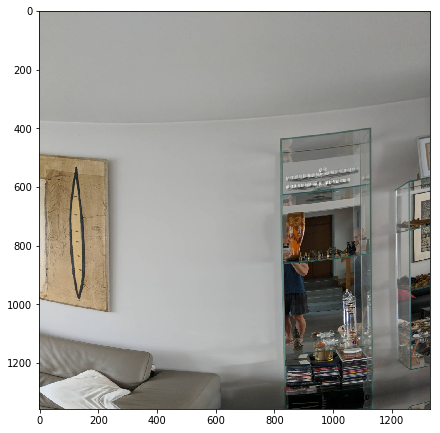

In [130]:
warped = my_warp(image, 1588, 706, 0, 0, 0)

It is said that cx and cy is the optical center of the camera. We can be sure its mearning here.

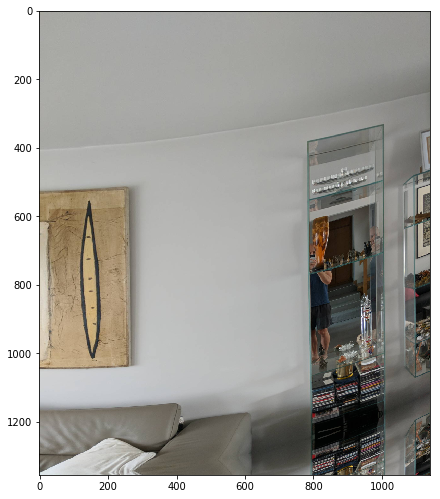

In [131]:
warped = my_warp(image, 1588, 0, 0, 0, 0)

## angles

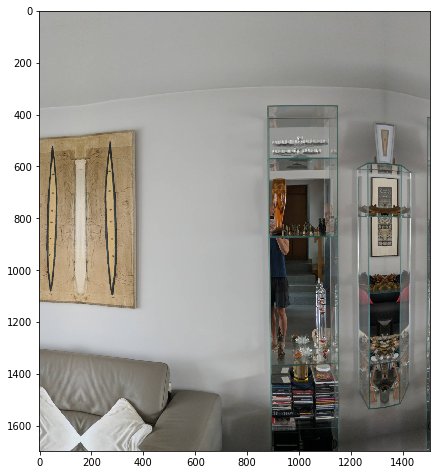

In [132]:
warped = my_warp(image, 1588, 706, 1008, utils.degree2radian(30), 0) # 

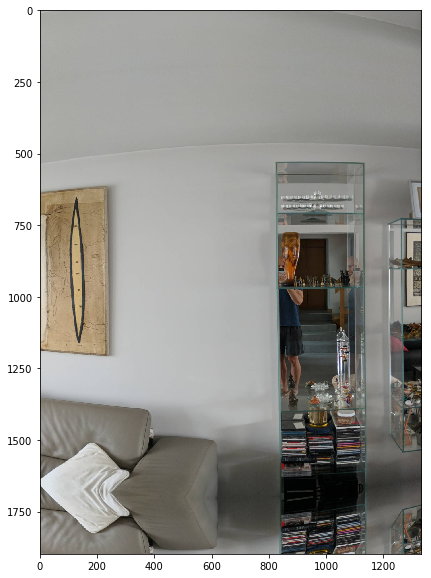

In [133]:
warped = my_warp(image, 1588, 706, 1008, 0, utils.degree2radian(30))

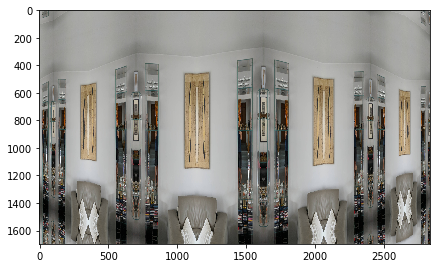

In [134]:
warped = my_warp(image, 1588, 706, 1008, utils.degree2radian(70), 0) # 

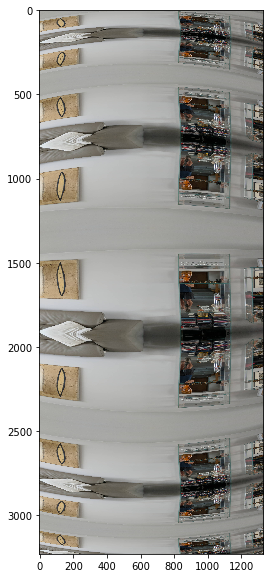

In [135]:
warped = my_warp(image, 1588, 706, 1008, 0, utils.degree2radian(70)) # 

Can you catch what the angles mean? I can't.

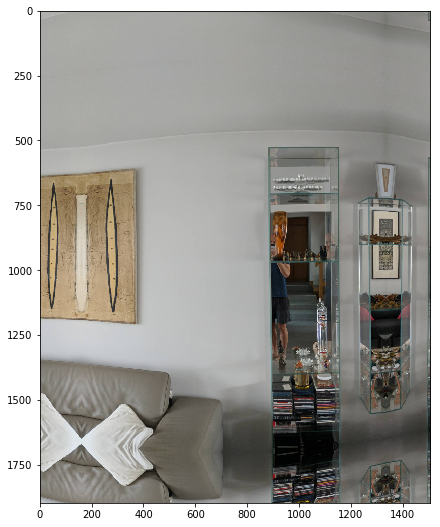

In [136]:
warped = my_warp(image, 1588, 706, 1008, utils.degree2radian(30), utils.degree2radian(30)) # 

It's obvious that the theta and huai are not related to our pitch and yaw values.

## Combine Rotation and Perspective Warp

### Perspective and then Rotation warp

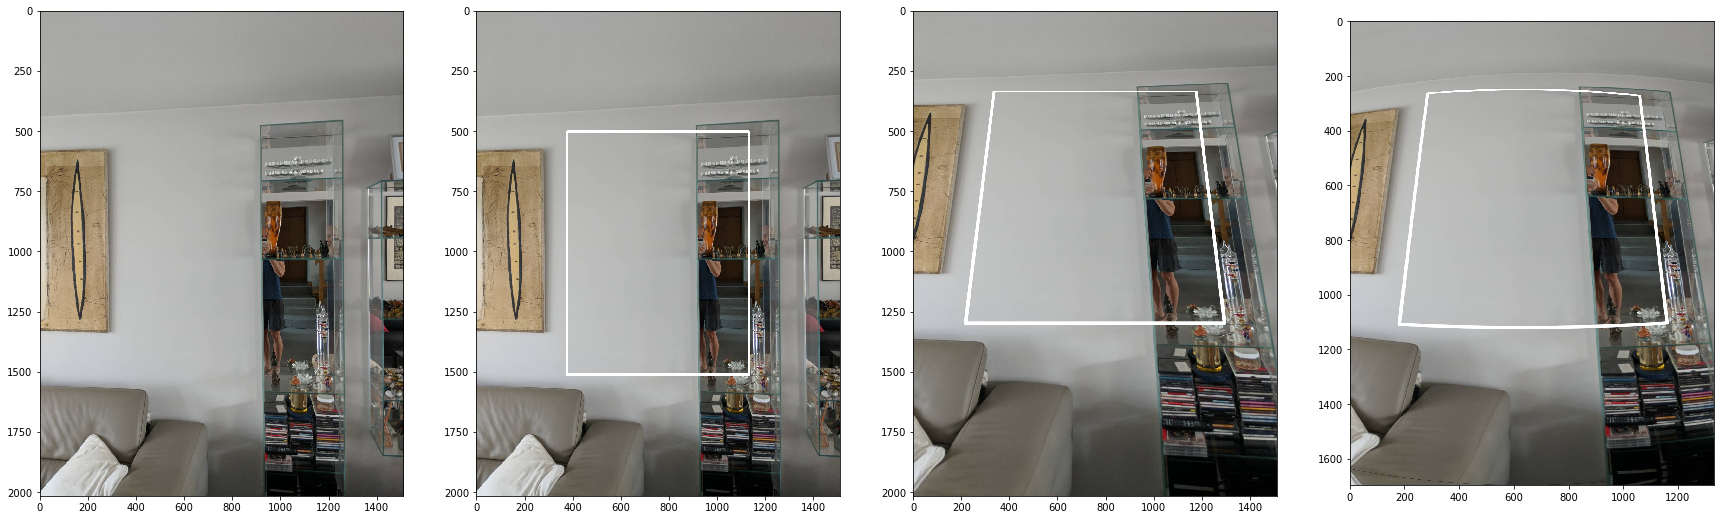

(2016, 1512, 3)
(2016, 1512, 3)
(1697, 1331, 3)


In [144]:
h, w, _ = image.shape
delta = 300 # for test

draw_pts = np.array([[w//4, h//4], [w*3//4, h//4], [w*3//4, h*3//4], [w//4, h*3//4]], np.int32)
src_pts = np.array([[0, 0], [w, 0],[w-delta, h], [delta, h]], np.int32)
dst_pts = np.array([[0, 0], [w, 0],[w, h],[0, h]], np.int32)

test_image = image.copy()
cv.polylines(test_image, [draw_pts], True, (255, 255, 255), 10)

H, status = cv.findHomography(src_pts, dst_pts)
warped = cv.warpPerspective(test_image, H, (w, h))

more_warped = my_warp(warped, 1588, 706, 1008, 0, 0, draw=False)

_, ax = plt.subplots(1, 4, figsize=(30, 10))
ax[0].imshow(image)
ax[1].imshow(test_image)
ax[2].imshow(warped)
ax[3].imshow(more_warped)
plt.show()

print(image.shape)
print(warped.shape)
print(more_warped.shape)


### Rotation and then Perspective warp

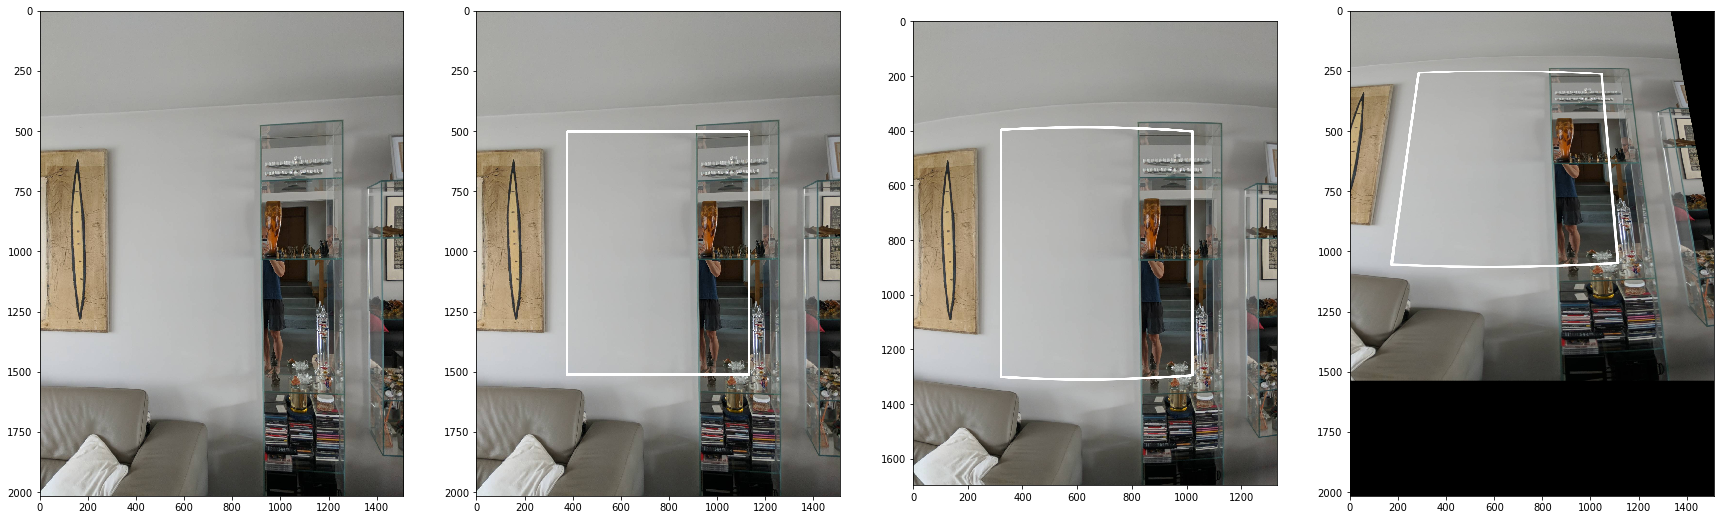

(2016, 1512, 3)
(1697, 1331, 3)
(2016, 1512, 3)


In [145]:
h, w, _ = image.shape
delta = 300 # for test

draw_pts = np.array([[w//4, h//4], [w*3//4, h//4], [w*3//4, h*3//4], [w//4, h*3//4]], np.int32)

src_pts = np.array([[0, 0], [w, 0],[w-delta, h], [delta, h]], np.int32)
dst_pts = np.array([[0, 0], [w, 0],[w, h],[0, h]], np.int32)

test_image = image.copy()
cv.polylines(test_image, [draw_pts], True, (255, 255, 255), 10)

warped = my_warp(test_image, 1588, 706, 1008, 0, 0, draw=False)

H, status = cv.findHomography(src_pts, dst_pts)
more_warped = cv.warpPerspective(warped, H, (w, h))

_, ax = plt.subplots(1, 4, figsize=(30, 10))
ax[0].imshow(image)
ax[1].imshow(test_image)
ax[2].imshow(warped)
ax[3].imshow(more_warped)
plt.show()

print(image.shape)
print(warped.shape)
print(more_warped.shape)


### What is better? Spherical->Perspective vs Perspective->Spherical

1. Spherical warp decreases the image size.
2. Spherical warp makes reflections in the curved area at the top and bottom of the image.
3. S->P and P->S gave us the same result. **Nothing is better.**

## Comparison of Spherical and Cylindrical

In [146]:
# the same function but only the warper type is different of cv.PyRotationWarper constructor.

def my_cylindrical_warp(img, f, cx, cy, theta, huai, draw=True, save=False):
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0,  1]], np.float32)    
    Rx = np.array([[1,               0,                0],
                   [0, math.cos(theta), -math.sin(theta)],
                   [0, math.sin(theta),  math.cos(theta)]])
    Ry = np.array([[math.cos(huai), 0, math.sin(huai)],
                   [0,              1,              0],
                   [-math.sin(huai),0, math.cos(huai)]])    
    R = Rx * Ry
    R = R.astype(np.float32)
    
    scale = 1500
    warper = cv.PyRotationWarper('cylindrical', scale)
    corner, image_wp = warper.warp(img, K, R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
    
    if draw:
        plt.figure(figsize=(7, 10))
        plt.imshow(image_wp)
        plt.show()

    if save:
        cv.imwrite('temp.jpg', cv.cvtColor(image_wp, cv.COLOR_RGB2BGR))

    return image_wp

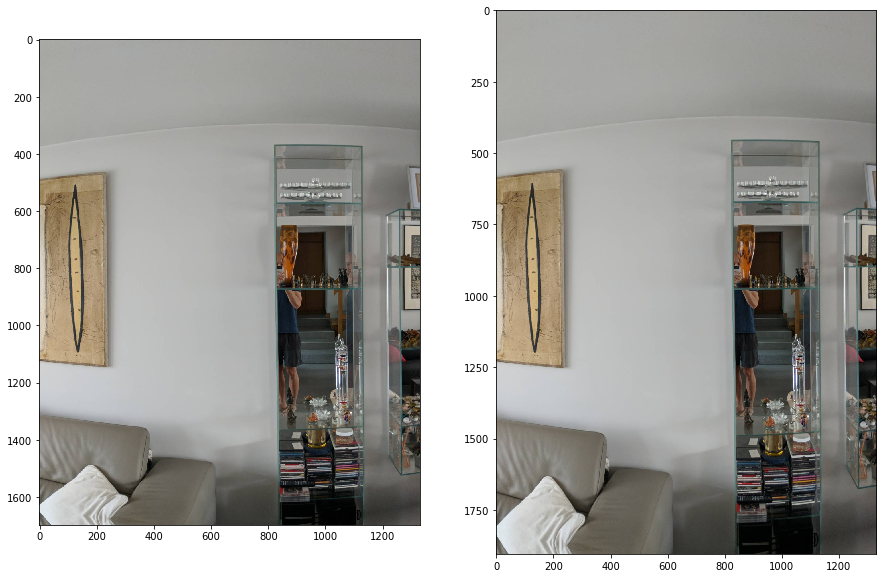

(1697, 1331, 3)
(1904, 1331, 3)


In [149]:
cylindrical = my_cylindrical_warp(image, 1588, 706, 1008, 0, 0, draw=False)
spherical = my_warp(image, 1588, 706, 1008, 0, 0, draw=False)

_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(spherical)
ax[1].imshow(cylindrical)
plt.show()

print(spherical.shape)
print(cylindrical.shape)


Two warpers give the similar result. Their only difference is the height of the result image and it's reasonable. Considering our purpose, the stitching 360 x 180 panorama, I think the spherical warping is better.

## Our own Cylindrical warper?

In [225]:
def cylindrical_warp(img, k):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_, w_ = img.shape[:2]

    # pixel coordinates
    y_i, x_i = np.indices((h_, w_))
    x = np.stack([x_i, y_i, np.ones_like(x_i)], axis=-1).reshape(h_ * w_, 3)  # to homography
    k_inv = np.linalg.inv(k)
    x = k_inv.dot(x.T).T  # normalized coordinates

    # calculate cylindrical coordinates (sin\theta, h, cos\theta)
    a = np.stack([np.sin(x[:, 0]), x[:, 1], np.cos(x[:, 0])], axis=-1).reshape(w_ * h_, 3)
    b = k.dot(a.T).T  # project back to image-pixels plane
    # back from homography coordinates
    b = b[:, :-1] / b[:, [-1]]
    # make sure warp coordinates only within image bounds
    b[(b[:, 0] < 0) | (b[:, 0] >= w_) | (b[:, 1] < 0) | (b[:, 1] >= h_)] = -1
    b = b.reshape(h_, w_, -1)

    # img_rgba = cv.cvtColor(img, cv.COLOR_BGR2BGRA)  # for transparent borders...
    # warp the image according to cylindrical coordinates
    img = cv.remap(img,
                   b[:, :, 0].astype(np.float32),
                   b[:, :, 1].astype(np.float32),
                   cv.INTER_AREA,
                   borderMode=cv.BORDER_CONSTANT,
                   borderValue=(0, 0, 0))

    # Crop black border
    cropper = ImageCropper.ImageCropper(img)
    cropped_image = cropper.crop()
    
    return cropped_image
    # ref: http://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv
    _, thresh = cv.threshold(cv.cvtColor(img, cv.COLOR_RGB2GRAY), 1, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv.boundingRect(contours[0])

    if w > 0 and h > 0:
        img = img[y:y + h, x:x + w]

    return img


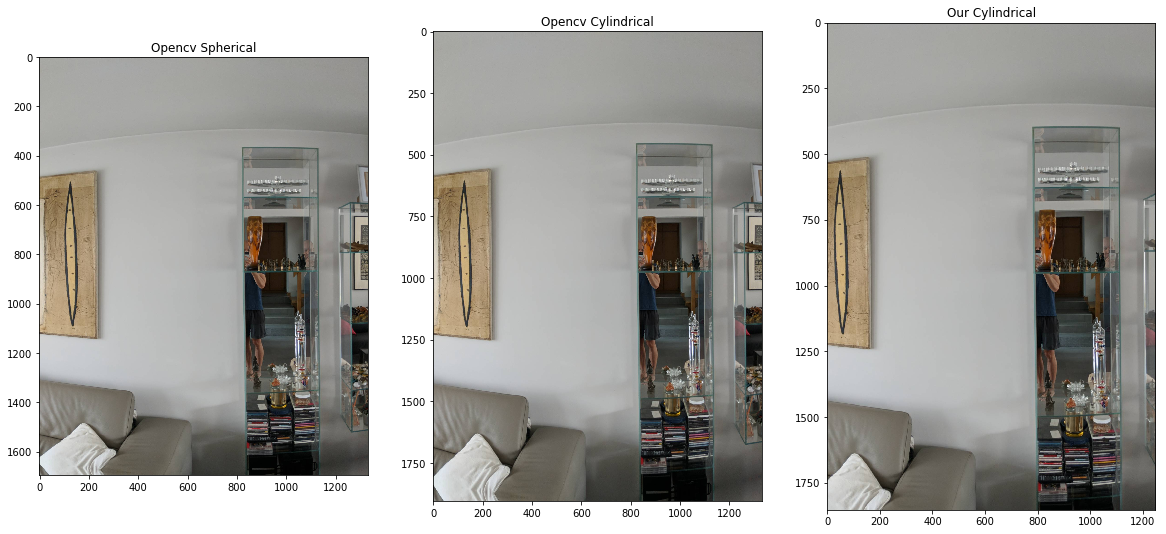

(1697, 1331, 3)
(1904, 1331, 3)
(1854, 1249, 3)


In [226]:
spherical = my_warp(image, 1588, 706, 1008, 0, 0, draw=False)
cylindrical = my_cylindrical_warp(image, 1588, 706, 1008, 0, 0, draw=False)
our_cylindrical = cylindrical_warp(image, K)

_, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(spherical)
ax[0].set_title('Opencv Spherical')
ax[1].imshow(cylindrical)
ax[1].set_title('Opencv Cylindrical')
ax[2].imshow(our_cylindrical)
ax[2].set_title('Our Cylindrical')
plt.show()

print(spherical.shape)
print(cylindrical.shape)
print(our_cylindrical.shape)

Our cylindrical warper doesn't reflect borders but it lose pixels in border areas. It's good for stitching and cropping.

# Conclusion

#### 1. OpenCV warpers are not suitable to spherical panoramas, but to cylindrical panoramas.
#### 2. Combination of spherical and perspective warping can improve the quality of stitching.
#### 3. The order of spherical and perspective warping doesn't affect the result.
#### 4. Warping shrinks the width and height of the image.